In [1]:
import sys

In [2]:
# global config
DATA_PATH = '/data/data/'
MODEL_PATH = '/data/models/'
DATABASE_PATH = '/data/database/'
PREFIX='.npy'

In [3]:
# Targic data
TARGET_PATH = 'T0955/'
TARGET_NAME = 'T0955'

In [4]:
# Set up target fiel
TARGET_DIR = DATA_PATH + TARGET_PATH
TARGET = TARGET_DIR + TARGET_NAME
TARGET_SEQ=TARGET+'.seq'
print(TARGET_SEQ)

/data/data/T0955/T0955.seq


In [5]:
%%bash
export PATH="/hh-suite/build/bin:/hh-suite/build/scripts:$PATH"

TARGET="T0955"
TARGET_DIR="/data/data/${TARGET}"
TARGET_SEQ="${TARGET_DIR}/${TARGET}.seq" # fasta format
PLMDCA_DIR="/plmDCA/plmDCA_asymmetric_v2/"

DATABASE_DIR="/data/database/hhblits/pdb70"
FEATURE_GENERATOR="/alphafold_pytorch/feature.py"

# generate domain crops from target seq
python3 $FEATURE_GENERATOR -s $TARGET_SEQ -c

for domain in ${TARGET_DIR}/*.seq; do
        out=${domain%.seq}
        echo "Generate MSA files for ${out}"
        hhblits -cpu 4 -i ${out}.seq -d ${DATABASE_DIR} -oa3m ${out}.a3m -ohhm ${out}.hhm -n 3
        reformat.pl ${out}.a3m ${out}.fas
        psiblast -subject ${out}.seq -in_msa ${out}.fas -out_ascii_pssm ${out}.pssm
        python3 $FEATURE_GENERATOR -s ${out}.seq -f
done

# make target features data and generate ungap target aln file for plmDCA
python3 $FEATURE_GENERATOR -s $TARGET_SEQ -f

cd $PLMDCA_DIR
for aln in ${TARGET_DIR}/*.aln; do
        echo "calculate plmDCA for $aln"
        octave plmDCA.m $aln
done

cd $TARGET_DIR

# run again to update target features data
python3 $FEATURE_GENERATOR -s $TARGET_SEQ -f

Generate MSA files for /data/data/T0955/T0955
Query         T0955 gHEEE_02, , 41 residues|
Match_columns 41
No_of_seqs    1 out of 2
Neff          1
Searched_HMMs 100
Date          Sun Jan 31 18:52:43 2021
Command       hhblits -cpu 4 -i /data/data/T0955/T0955.seq -d /data/database/hhblits/pdb70 -oa3m /data/data/T0955/T0955.a3m -ohhm /data/data/T0955/T0955.hhm -n 3 

 No Hit                             Prob E-value P-value  Score    SS Cols Query HMM  Template HMM
  1 5W9F_A De novo mini protein gH 100.0 1.1E-35 7.9E-40  161.1   0.0   41    1-41      1-41  (41)
  2 6QET_A Gallinacin-11; new fold  45.0     3.1 0.00022   20.7   0.0   19   23-41     11-31  (42)
  3 1SS3_A Pollen allergen Ole e 6  39.9     3.5  0.0003   20.2   0.0   20    6-25     14-33  (50)
  4 2J4U_X OUTER MEMBRANE PROTEIN   38.9     2.4 0.00032   16.7   0.0   14    4-17     15-28  (45)
  5 6QEU_A Gallinacin-11; new fold  26.9     9.3 0.00068   20.9   0.0   27   11-40     42-70  (82)
  6 1M2S_A Toxin BmTX3; alpha/beta  

- 18:52:42.536 INFO: Search results will be written to /data/data/T0955/T0955.hhr

- 18:52:42.568 INFO: Searching 85757 column state sequences.

- 18:52:42.636 INFO: /data/data/T0955/T0955.seq is in A2M, A3M or FASTA format

- 18:52:42.636 INFO: Iteration 1

- 18:52:42.655 INFO: Prefiltering database

- 18:52:42.702 INFO: HMMs passed 1st prefilter (gapless profile-profile alignment)  : 155

- 18:52:42.702 INFO: HMMs passed 2nd prefilter (gapped profile-profile alignment)   : 100

- 18:52:42.702 INFO: HMMs passed 2nd prefilter and not found in previous iterations : 100

- 18:52:42.702 INFO: Scoring 100 HMMs using HMM-HMM Viterbi alignment

- 18:52:42.890 INFO: Alternative alignment: 0

- 18:52:42.893 INFO: 100 alignments done

- 18:52:42.894 INFO: Alternative alignment: 1

- 18:52:42.894 INFO: 4 alignments done

- 18:52:42.894 INFO: Alternative alignment: 2

- 18:52:42.894 INFO: Alternative alignment: 3

- 18:52:43.019 INFO: Premerge done

- 18:52:43.019 INFO: Realigning 10 HMM-HMM alig

In [6]:
import torch
import time
import argparse

import numpy as np
import multiprocessing as mp

sys.path.append('../alphafold_pytorch')
import utils
from alphafold import run_eval, ensemble
from pathlib import Path
from network import ContactsNet
from dataset import ProteinDataLoader
from datetime import datetime

In [7]:
targetFile=TARGET + PREFIX
outputDir= TARGET + "_out"
print(targetFile)
print(outputDir)
timestr = datetime.now().strftime('%Y_%m_%d_%H_%M_%S')

/data/data/T0955/T0955.npy
/data/data/T0955/T0955_out


In [8]:
print("Saving output to " + outputDir)

Saving output to /data/data/T0955/T0955_out


In [9]:
startTime = time.time()

# multi processer
ctx = mp.get_context('spawn')
numParallelProcesser = 0
processes = []

# multi gpus
isEvenlyDistributed = True
isGPU = True

devices = []
if torch.cuda.is_available() and isGPU :
    numDevices = torch.cuda.device_count()
    for deviceIndex in range(0, numDevices):
        devices.append("cuda:" + str(deviceIndex))
else:
    devices = ["cpu"]

target = targetFile.split('/')[-1].split('.')[0]

In [10]:
# running loop
numDevices = len(devices)
count = 0

for replica in range(0, 4):
    mode = ["D","B"]
    if replica == 0 :
        mode = ["D","B", "T"]
        
    for m in mode:
        device = devices[count % numDevices]
        if isEvenlyDistributed:
            count = count + 1
        print("Lauching model: " + m + " " + str(replica) + " on device " + device)
        
        if m == 'D':
            modelType = "Distogram"
            modelPath = Path(MODEL_PATH + "/873731")
        elif m == 'B':
            modelType = "Background"
            modelPath = Path(MODEL_PATH + "/916425")
        elif m == 'T':
            modelType = "Torsion"
            modelPath = Path(MODEL_PATH + "/941521")
            
        outDir = outputDir + "/" + modelType + "/" + str(replica)
        Path(outDir).mkdir(parents=True, exist_ok=True)
        
        print("Input file: " + targetFile)
        print("Output dir: " + outDir)
        print(modelType + " model: " + str(modelPath))
        print("Replica: " + str(replica))
        print("Device: " + str(device))
        # run mode
        # run_eval(targetFile, modelPath, str(replica), Path(outDir), device)
        p = ctx.Process(target=run_eval, args=(targetFile, modelPath, str(replica), Path(outDir), device))
        processes.append(p)
        p.start()
        if len(processes) == numParallelProcesser:
            for p in processes:
                p.join()
            processes = []

if len(processes) > 0:
    for p in processes:
        p.join()
    processes = []

print("All models have been running for %s seconds ---" % (time.time() - startTime))

Lauching model: D 0 on device cuda:0
Input file: /data/data/T0955/T0955.npy
Output dir: /data/data/T0955/T0955_out/Distogram/0
Distogram model: /data/models/873731
Replica: 0
Device: cuda:0
Lauching model: B 0 on device cuda:1
Input file: /data/data/T0955/T0955.npy
Output dir: /data/data/T0955/T0955_out/Background/0
Background model: /data/models/916425
Replica: 0
Device: cuda:1
Lauching model: T 0 on device cuda:0
Input file: /data/data/T0955/T0955.npy
Output dir: /data/data/T0955/T0955_out/Torsion/0
Torsion model: /data/models/941521
Replica: 0
Device: cuda:0
Lauching model: D 1 on device cuda:1
Input file: /data/data/T0955/T0955.npy
Output dir: /data/data/T0955/T0955_out/Distogram/1
Distogram model: /data/models/873731
Replica: 1
Device: cuda:1
Lauching model: B 1 on device cuda:0
Input file: /data/data/T0955/T0955.npy
Output dir: /data/data/T0955/T0955_out/Background/1
Background model: /data/models/916425
Replica: 1
Device: cuda:0
Lauching model: D 2 on device cuda:1
Input file: /

Ensembling all replica outputs & Pasting contact maps


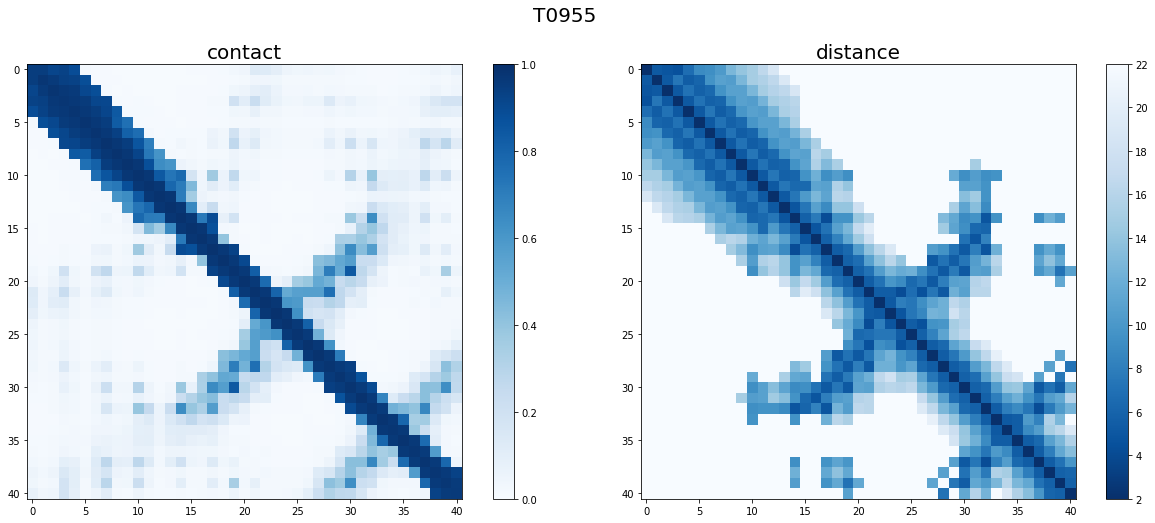

In [11]:
print("Ensembling all replica outputs & Pasting contact maps")
ensemble(targetFile, Path(outputDir))

In [12]:
sys.path.append('../alphafoldv1')

import pickle
import tensorflow as tf  

sys.path.append('../alphafoldv1')

from make_constraints import *
from make_torsion_stats import *

TARGET_TORSION = TARGET_DIR + TARGET_NAME + '_out/Torsion/0/' + TARGET_NAME + '.torsion'
TARGET_PDB_TEMP_OUT = TARGET_DIR + TARGET_NAME + '_out/' + TARGET_NAME + '.pickle'

f = tf.io.gfile.GFile(TARGET_TORSION, 'rb')
torsion_probs = pickle.load(f, encoding='latin1')

seq_file = Path(TARGET_SEQ)
target_line, *seq_line = seq_file.read_text().split('\n')
target = seq_file.stem
suffix = seq_file.suffix
sequence = ''.join(seq_line)


PhiPsiList = []

for i in range(torsion_probs.shape[0]):
    print("Calculating torsion stats for residue %d" %(i+1))
    phipsi_stat = CalcTorsionStats(torsion_probs[i])
    print(phipsi_stat)
    PhiPsiList.append(phipsi_stat)

save_torsions_stats(TARGET_PDB_TEMP_OUT,PhiPsiList,sequence)

print("Finish saving file")


Calculating torsion stats for residue 1
(-1.4458284899296303, 2.764774623020201, 0.5046641130791264, 0.6460257175790294)
Calculating torsion stats for residue 2
(-1.0990333516320385, -0.6846958431195405, 0.0680901924254697, 0.0673711167127052)
Calculating torsion stats for residue 3
(-1.160280274127916, -0.7739536764626589, 0.027481923675803908, 0.039680777716437646)
Calculating torsion stats for residue 4
(-1.1630117333314627, -0.7425468284072001, 0.0313058271433612, 0.03949636599540247)
Calculating torsion stats for residue 5
(-1.0792545597179886, -0.709500702040475, 0.02213928412235495, 0.034835120021404924)
Calculating torsion stats for residue 6
(-1.1652447318173522, -0.7510734533232621, 0.030882654488983533, 0.04424365144614328)
Calculating torsion stats for residue 7
(-1.1610702928297123, -0.6731783390707187, 0.021142626624512505, 0.029069199430630344)
Calculating torsion stats for residue 8
(-1.1934867347910103, -0.6805002260455711, 0.02734806474823295, 0.044984689223010375)
Ca

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1715: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return integrate.quad(self._mom_integ1, 0, 1, args=(m,)+args)[0]


(-2.054080376528675, 2.372362611370969, 0.11092216146088842, 0.11270479352291529)
Calculating torsion stats for residue 22
(-2.011758984147127, 2.4959081668194933, 0.15642046809959964, 0.1452494383538127)
Calculating torsion stats for residue 23
(-1.5135583353277395, 2.4075897549978507, 0.42118433540505074, 0.7378042168719723)
Calculating torsion stats for residue 24
(-1.1174694210559077, -0.44370716027449786, 0.7010177163695328, 0.6012807682630366)
Calculating torsion stats for residue 25
(-1.2869984154038447, -0.5863442132732055, 0.9393964769028675, 1.103012638157867)
Calculating torsion stats for residue 26
(-1.3576064675619388, 0.5966315368891277, 2.6486879183216487, 1.3398683624510654)
Calculating torsion stats for residue 27
(-1.7078571569610337, 1.1307051064526485, 1.0642738546566781, 2.4143600404755574)
Calculating torsion stats for residue 28
(-2.1053411955838652, 2.3961568922064918, 0.3670752195469547, 0.278698995281129)
Calculating torsion stats for residue 29
(-2.1259688582

In [13]:
TARGET_DISTENCE = TARGET_DIR + TARGET_NAME + '_out/Distogram/ensemble/' + TARGET_NAME + '.distance'
TARGET_HIST = TARGET_DIR + TARGET_NAME + '_out/' + TARGET_NAME + '_hist'
TARGET_OUT = TARGET_DIR + TARGET_NAME + '_out/' + TARGET_NAME + '_test'

f = tf.io.gfile.GFile(TARGET_DISTENCE, 'rb')

probs = pickle.load(f, encoding='latin1')

potential = CalcPotentialByDFIRE(probs)
pairConstraints = GenerateSplinePotential4Distance(sequence,potential)
WriteSplineConstraints(pairConstraints, savefile=TARGET_OUT, savefolder4histfile=TARGET_HIST)


f = tf.io.gfile.GFile(TARGET_PDB_TEMP_OUT, 'rb')

contact_dict = pickle.load(f, encoding='latin1')

#print(contact_dict.keys())
PhiPsiList = contact_dict['torsion_stats']
sequence = contact_dict['sequence']

#print(PhiPsiList)

PhiPsiConstraints = GeneratePhiPsiPotential(sequence, PhiPsiList)
#print(PhiPsiConstraints)


with open(TARGET_OUT, 'a') as fh:
    fh.write('\n'.join(PhiPsiConstraints) )
    
print("finished generate temp files")

finished generate temp files


In [16]:
%%bash
TARGET="T0955"
TARGET_DIR="/data/data/${TARGET}"

cd /alphafoldv1
python fold.py --fasta ${TARGET_DIR}/${TARGET}.seq --constraints ${TARGET_DIR}/${TARGET}_out/${TARGET}_test --out ${TARGET_DIR}/${TARGET}_out/${TARGET}.pdb
# python make_pdb_image.py --pdb ${TARGET_DIR}/${TARGET}_out/${TARGET}.pdb --sec ${TARGET_DIR}/${TARGET}_out/Torsion/0/${TARGET}.sec -o ${TARGET_DIR}/${TARGET}_out/${TARGET}_pdb.png

core.init: Checking for fconfig files in pwd and ./rosetta/flags 
core.init: Rosetta version: PyRosetta4.Release.python36.ubuntu r274 2020.50+release.1295438cd4b 1295438cd4bd2be39c9dbbfab8db669ab62415ab http://www.pyrosetta.org 2020-12-12T00:30:01
core.init: command: PyRosetta -ex1 -ex2aro -database /usr/local/lib/python3.6/dist-packages/pyrosetta/database
basic.random.init_random_generator: 'RNG device' seed mode, using '/dev/urandom', seed=537255251 seed_offset=0 real_seed=537255251
basic.random.init_random_generator: RandomGenerator:init: Normal mode, seed=537255251 RG_type=mt19937
core.chemical.GlobalResidueTypeSet: Finished initializing fa_standard residue type set.  Created 985 residue types
core.chemical.GlobalResidueTypeSet: Total time to initialize 0.519949 seconds.
core.chemical.GlobalResidueTypeSet: Finished initializing centroid residue type set.  Created 69 residue types
core.chemical.GlobalResidueTypeSet: Total time to initialize 0.013371 seconds.
core.scoring.constraints